# Env setups
(SAGINEnv_v1_1)

In [1]:
import numpy  as np

seed = 7
max_cycles = 300
uav_init_mode = 'specific'  # ['random', 'kmeans', 'specific']
# uav_init_locs = 1000 * np.array([
#     [-1, 1],
#     [-1, -1],
#     [1, -1]
# ]).transpose()
uav_init_locs = 1000 * np.array([
    [1, 1],
    [1, 1],
    [1, 1]
]).transpose()
user_mode = "random walk"   # "stationary", "random walk"
user_velocity = 10
link_assignment = "greedy (drate)"  # "greedy (drate)", "kmeans"

# For plotting
log_avg_drates_dict = dict()
log_n_satisfied_dict = dict()

### Utility funcs

In [2]:
import matplotlib
import matplotlib.pyplot as plt

def plot_uav_movements(env, log_uav_locs, fpath, legend=True, figsize=(6,6)):
    """ PLOTTING: MOVEMENTS OF UAVs """
    mbs_locs = env.unwrapped.locs['mbs']
    log_uav_locs = np.array(log_uav_locs)       # shape = (n_steps, 2, n_uavs)
    user_locs = env.unwrapped.locs['user']
    n_mbss = mbs_locs.shape[-1] 
    n_uavs = log_uav_locs.shape[-1]
    n_users = user_locs.shape[-1]

    satisfied = env.unwrapped.infos['global']['drates'] >= env.unwrapped.drate_threshold
    bs_mapping = env.unwrapped.infos['global']['bs_mapping']

    markers = {True: "o", False: "v"}       # satisfied vs unsatisfied
    mfcs = {True: "None", False: ""}        # satisfied vs unsatisfied
    colors = list(matplotlib.colors.TABLEAU_COLORS)   # encoded for different base stations

    fig = plt.figure(figsize=figsize)
    ax = fig.gca()

    for mbs_id in range(n_mbss):
        ax.plot(mbs_locs[0][mbs_id], mbs_locs[1][mbs_id], 's', color=colors[mbs_id],
                    mec='k', mew=0.8, markersize=7, label='macro BS')

    for i in range(n_users):
        # axs.scatter(user_locs[0][i], user_locs[1][i], s=15,
        #             marker=markers[satisfied[i]], color=colors[bs_mapping[i]])
        if satisfied[i] == True:
            ax.plot(user_locs[0][i], user_locs[1][i], marker=markers[satisfied[i]],
                    markerfacecolor="None", color=colors[bs_mapping[i]], markersize=5)
        else: 
            ax.plot(user_locs[0][i], user_locs[1][i], marker=markers[satisfied[i]],
                    color=colors[bs_mapping[i]], markersize=5)
        
    for uav_id in range(n_uavs):
        loc_uav = log_uav_locs[:, :, uav_id].transpose()
        ax.plot(loc_uav[0][3:], loc_uav[1][3:], color=colors[n_mbss + uav_id],
                 linestyle=":", alpha=0.9) # trajectory
        # if uav_id == n_uavs - 1:
        #     l_init, l_final = "init loc", "final loc"
        # else:
        #     l_init, l_final = "", ""
        # axs.plot(loc_uav[0][0], loc_uav[1][0], 'ok',
        #         markerfacecolor="None", label=l_init) # mec=colors[n_mbss + uav_id]
        # axs.plot(loc_uav[0][-1], loc_uav[1][-1], 'sk',
        #         markerfacecolor="None", label=l_final) # mec=colors[n_mbss + uav_id]
        ax.plot(loc_uav[0][-1], loc_uav[1][-1], 's', color=colors[n_mbss + uav_id],
                mec='k', mew=0.8, markersize=7, label=f"UAV {uav_id}") # final position

    offset = 40
    ax.set_xlim(-1000 - offset, 1000 + offset)
    ax.set_ylim(-1000 - offset, 1000 + offset)
    ax.grid(visible=True, linestyle='--')
    if legend == True:
        fig.legend(ncol=4, loc='upper center')

    fig.savefig("tmp/trajectory.png")
    plt.savefig(fpath, dpi=300)
    plt.show()

def plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict, figsize=(5,3), path=None):
    n_users = env.unwrapped.n_users

    """ PLOT: NUMBER OF SATISFIED USERS"""
    fig, ax = plt.subplots(figsize=figsize)
    for name, log_n_satisfied in log_n_satisfied_dict.items():
        log_n_satisfied = np.asanyarray(log_n_satisfied)
        ax.plot(log_n_satisfied/n_users*100, label=name)
    ax.set_xlabel('movement step')
    ax.set_ylabel('percentage of satisfied users (%)')
    ax.set_xlim(left=0, right=max_cycles)
    ax.set_ylim(bottom=50, top=100)
    ax.margins(0, 0)
    ax.grid(visible=True, linestyle='--')
    ax.legend()
    fig.tight_layout(pad=0.5)
    if path is not None:
        plt.savefig(path + "n_satisfied_users.png", dpi=300)
    plt.show()

    """ PLOTTING: DATA RATES"""
    fig, ax = plt.subplots(figsize=figsize)
    for name, log_avg_drates in log_avg_drates_dict.items():
        log_avg_drates_Mbps = np.asanyarray(log_avg_drates)/1e6
        ax.plot(log_avg_drates_Mbps, label=name)
    ax.set_xlabel('movement step')
    ax.set_ylabel('average data rate (Mbps)')
    ax.set_xlim(left=0, right=max_cycles)
    ax.set_ylim(bottom=45, top=70)
    ax.margins(0, 0)
    ax.grid(visible=True, linestyle='--')
    ax.legend()
    fig.tight_layout(pad=0.5)
    if path is not None:
        plt.savefig(path + "data_rate.png", dpi=300)
    plt.show()


# Benchmarking

### Kmeans + PPO

In [3]:
# run the following command in the terminal
# tensorboard --logdir=code/runs --reload_multifile True --port=6007

In [2]:
import os

print(os.getcwd())

c:\Users\linhh\OneDrive\Documents\Git\j3-uavbs-placement-marl\uavbs-placement-marl-dev\code\archive


In [4]:
from envs.sagin_v1 import *
from envs.utils import *
from stable_baselines3 import PPO
import torch
from stable_baselines3.common.env_checker import check_env


n_steps = 128 * 20_000

env = SingleDroneEnv(
    max_cycles=128,
)
env.reset(seed=42)

check_env(env)

model = PPO(
    policy = "MlpPolicy",
    env = env,
    # learning_rate = 1e-3,   # default: 3e-4
    # n_steps = 512, # no of steps to run for each environment per update
    # batch_size = 32,
    # ent_coef = 0.1,
    # vf_coef = 0.1,
    tensorboard_log = "sarl/runs",
    # policy_kwargs = {
    #     "activation_fn": torch.nn.ReLU,
    #     "net_arch": dict(vf=[1024, 512], pi=[1024, 512]),  # "net_arch": [1024, 512,],
    # },
    device = "cuda",
    # verbose=1,
)

model.learn(
    total_timesteps=n_steps,
    progress_bar=True
)

# model.save(f"sarl/trained_agents/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/ppo")
model.save(f"sarl/trained_agents/ppo_{n_steps/1e3:.0f}k")


ModuleNotFoundError: No module named 'envs'

In [ ]:
from envs.sagin_v1 import *
from envs.utils import *
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env


env = SingleDroneEnv(
        max_cycles=256,
        seed=None,
        uav_init_mode='specific',
        uav_init_locs=np.array([1000, 1000]).reshape(2, -1)
)
check_env(env)
# model = PPO.load(f"sarl/trained_agents/ppo_{n_steps/1e3:.0f}k")
# model = PPO.load("sarl/trained_agents/ppo_1280k")
model = PPO.load("sarl/trained_agents/stable/ppo_2560k_max_drate")

Terminated with 91/256 steps
UAV's final position: [0.56278139 0.51275638]
Image saved to /mnt/newdiskpartition/uavbs-placement-marl/code/sarl/images/observation.png


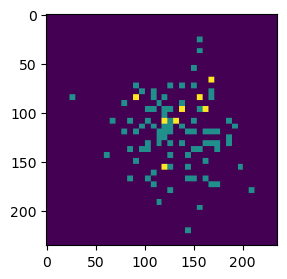

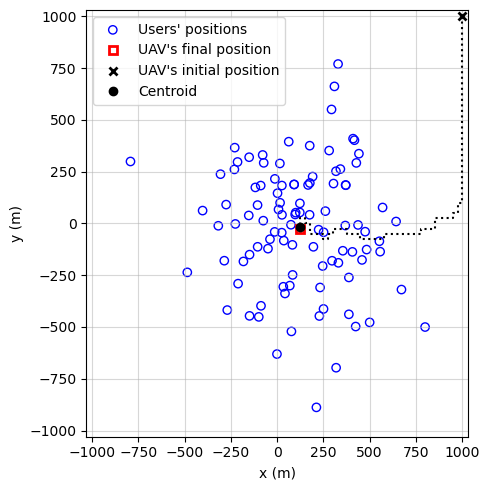

In [ ]:
observation, info = env.reset(seed=None)
log_uav_locs = env.locs['self']
while True:
        # action = env.action_space.sample()  # agent policy that uses the observation and info
        action, _states = model.predict(observation)        # deterministic=True
        observation, reward, terminated, truncated, info = env.step(action.item())
        log_uav_locs = np.append(log_uav_locs, env.locs['self'], axis=1)

        if terminated or truncated:
                break

print(f"Terminated with {1 + env.n_steps}/{env.max_cycles} steps")
# env.close()

""" TEST: OBSERVATIONS OF THE AGENT """
ob_last = observation.copy()
print(f"UAV's final position: {ob_last[:2]}")
hm = ob_last[2:].reshape(40, -1)
save_img_from_rgba_arr(hm, transparent=False, fpath="sarl/images/observation.png")

fig, ax = plt.subplots(figsize=(3,3))
im = plt.imread("sarl/images/observation.png")
ax.imshow(im)
plt.show()


""" PLOTTING: TRAJECTORY """
log_uav_locs = np.array(log_uav_locs)
x_drone = log_uav_locs[0]
y_drone = log_uav_locs[1]
x_users = env.locs['user'][0]
y_users = env.locs['user'][1]
bound = env.bound

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_users, y_users, marker='o', facecolors='none', edgecolors='b')
ax.scatter(x_users[-1], y_users[-1], marker='o', facecolors='none', 
           edgecolors='b', label="Users' positions"
)
ax.plot(x_drone, y_drone, ":", color="k")
ax.plot(x_drone[-1], y_drone[-1], marker='s', markerfacecolor='none',
        markeredgecolor = 'r', markeredgewidth=2, linestyle='none',
        label="UAV's final position"
)
ax.plot(x_drone[0], y_drone[0], marker='x', color='k', markeredgewidth=2,
        linestyle='none', label="UAV's initial position"
)
ax.plot(np.mean(x_users), np.mean(y_users), 'ok', label="Centroid")

plt.xlim(-bound - 30, bound + 30)
plt.ylim(-bound - 30, bound + 30)
plt.grid(True, alpha=0.5)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.tight_layout()

plt.savefig(fname='sarl/images/trajectory.png')
plt.show()

In [ ]:
# plot_uav_movements(env, log_uav_locs, fpath='sarl/images/illustration.png')

### PPO-based MARL

In [ ]:
from envs.sagin_v1 import *
from envs.utils import *
from ppo_sagin_v1_1 import *

device = torch.device('cuda')
torch.set_default_dtype(torch.float64)

""" ENV SETUP """
env = parallel_env(
    seed=seed,
    max_cycles=max_cycles,
    uav_init_mode=uav_init_mode,
    uav_init_locs=uav_init_locs,
    link_assignment=link_assignment,
    user_mode=user_mode,
    user_velocity=user_velocity,
)
obs, infos = env.reset(seed=None)
num_agents = len(env.possible_agents)
num_actions = env.action_space(env.possible_agents[0]).n
obs_shape = env.observation_space(env.possible_agents[0]).shape

""" LOAD THE TRAINED AGENT """
agent = Agent(obs_len=obs_shape[0], num_actions=num_actions).to(device)

# folder = "20240318-044445 (20k, run 1)"          # stable
# folder = "20240319-060814 (20k, run 2)"
# folder = "20240319-181056 (20k, run 3)"
# folder = "20240320-102038 (30k, run 1)"
# folder = "20240321-065743 (30k, run 2)"
# folder = "20240322-072249 (20k, run  5, dr_rw=0.8)"
# folder = "20240323-034204 (20k, run 6, dr_rw=0.2)"
folder = "20240323-175732 (20k, run 7, dr_rw=0.2)"

### not statble if starting from the top-right corner, why?
# folder = "20240321-200529 (20k, run 4, lr=5e-4)"

PATH = "trained_agents/selected/" + folder + "/model.tar"
checkpoint = torch.load(PATH)
agent.load_state_dict(checkpoint['model_state_dict'])
agent.eval()

""" TEST THE AGENT IN A NEW ENV """
step = 0
log_uav_locs = []
log_drates = []
log_avg_drates = []
log_n_satisfied = []

with torch.no_grad():
    obs = batchify_obs(obs, device)
    terms = [False]
    truncs = [False]
    while not any(terms) and not any(truncs):
        # loggging
        log_uav_locs.append(env.unwrapped.locs['uav'].copy())
        log_drates.append(env.unwrapped.infos['global']['drates'])
        log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
        log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

        actions, logprobs, _, values = agent.get_action_and_value(obs)
        obs, rewards, terms, truncs, infos = env.step(unbatchify(actions, env))
        obs = batchify_obs(obs, device)
        terms = [terms[a] for a in terms]
        truncs = [truncs[a] for a in truncs]
        
        step += 1

    env.close()

""" PLOTTING """
fpath = 'comp/marl.png'
plot_uav_movements(env, log_uav_locs, fpath)
log_avg_drates_dict["MARL"] = log_avg_drates
log_n_satisfied_dict["MARL"] = log_n_satisfied
# plot_stats(env, {"MARL": log_avg_drates}, {"MARL": log_n_satisfied})


NameError: name 'plot_uav_movements' is not defined

### Kmeans

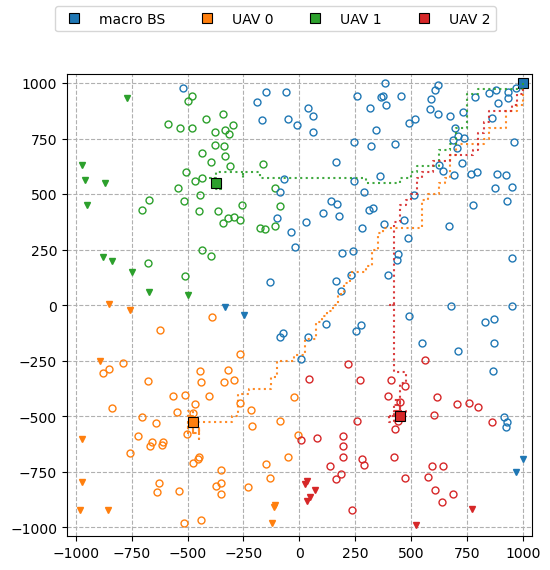

In [ ]:
from kmeans import *

""" ENV SETUP """
env = parallel_env(
    seed=seed,
    max_cycles=max_cycles,
    uav_init_mode=uav_init_mode,
    uav_init_locs=uav_init_locs,
    link_assignment=link_assignment,
    user_mode=user_mode,
    user_velocity=user_velocity
)
obs, infos = env.reset(seed=None)

""" K-MEANS AGENT """
agent = Kmeans_Agent(env=env)

""" TEST THE AGENT IN A NEW ENV """
step = 0
log_uav_locs = []
log_drates = []
log_avg_drates = []
log_n_satisfied = []

with torch.no_grad():
    # obs = batchify_obs(obs, device)
    terms = [False]
    truncs = [False]
    while not any(terms) and not any(truncs):
        # loggging
        log_uav_locs.append(env.unwrapped.locs['uav'].copy())
        log_drates.append(env.unwrapped.infos['global']['drates'])
        log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
        log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

        actions = agent.get_actions(
            user_locs=env.unwrapped.locs['user'],
            mbs_locs=env.unwrapped.locs['mbs'],
            uav_locs=env.unwrapped.locs['uav']
        )
        obs, rewards, terms, truncs, infos = env.step(actions)
        # obs = batchify_obs(obs, device)
        terms = [terms[a] for a in terms]
        truncs = [truncs[a] for a in truncs]

        step += 1

    env.close()

""" PLOTTING """
fpath = 'comp/kmeans.png'
plot_uav_movements(env, log_uav_locs, fpath)
log_avg_drates_dict["K-means"] = log_avg_drates
log_n_satisfied_dict["K-means"] = log_n_satisfied
# plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict)

### Stationary UAVs

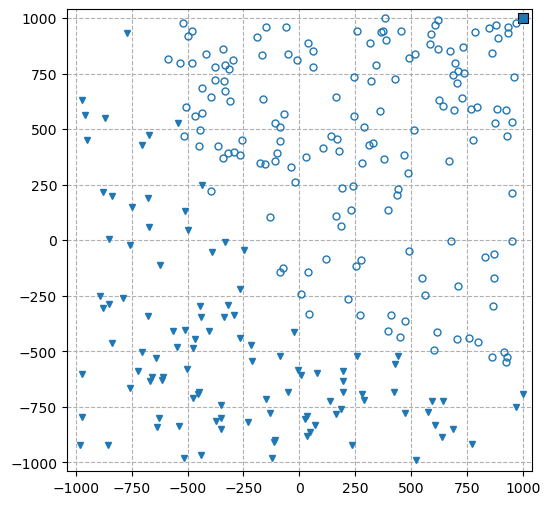

In [ ]:
from pettingzoo import ParallelEnv
from ppo_sagin_v1_1 import *
from envs.sagin_v1 import *
from envs.utils import *
from copy import deepcopy

class StationaryUAVs:
    def __init__(self, env:ParallelEnv) -> None:
        self.env = env
        self.n_uavs = env.unwrapped.n_uavs
        self._action_to_direction = deepcopy(env.unwrapped._action_to_direction)
        self.stationary_action_id = self.get_stationary_action_id()
    
    def get_actions(self):
        actions = {}
        for i in range(self.n_uavs):
            actions["uav_" + str(i)] = self.stationary_action_id

        return actions

    def get_stationary_action_id(self):
        """Get the id of the stationary decision (no movement)."""
        for id, action in self.env.unwrapped._action_to_direction.items():
            if np.all(action == np.array([0, 0])):
                return id

""" ENV SETUP """
env = parallel_env(
    seed=seed,
    max_cycles=max_cycles,
    uav_init_mode = uav_init_mode,
    uav_init_locs=uav_init_locs,
    link_assignment=link_assignment,
    user_mode=user_mode,
    user_velocity=user_velocity
)
obs, infos = env.reset(seed=None)

""" K-MEANS AGENT """
agent = StationaryUAVs(env=env)

""" TEST THE AGENT IN A NEW ENV """
step = 0
log_uav_locs = []
log_drates = []
log_avg_drates = []
log_n_satisfied = []

with torch.no_grad():
    # obs = batchify_obs(obs, device)
    terms = [False]
    truncs = [False]
    while not any(terms) and not any(truncs):
        log_uav_locs.append(env.unwrapped.locs['uav'].copy())
        log_drates.append(env.unwrapped.infos['global']['drates'])
        log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
        log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

        actions = agent.get_actions()
        obs, rewards, terms, truncs, infos = env.step(actions)
        terms = [terms[a] for a in terms]
        truncs = [truncs[a] for a in truncs]
        
        step += 1

    env.close()

""" PLOTTING """
fpath = 'comp/no_uavs.png'
plot_uav_movements(env, log_uav_locs=[], fpath=fpath, legend=False)
# log_avg_drates_dict["No UAV-BSs"] = log_avg_drates
# log_n_satisfied_dict["No UAVs"] = log_n_satisfied
# plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict)

### Random Movements

In [ ]:
# from pettingzoo import ParallelEnv
# from ppo_sagin_v1_1 import *
# from envs.sagin_v1 import *
# from envs.utils import *
# from copy import deepcopy

# class RandomMovements:
#     def __init__(self, env:ParallelEnv) -> None:
#         self.env = env
#         self.n_uavs = env.unwrapped.n_uavs
#         self.n_actions = env.action_space(env.possible_agents[0]).n

#     def get_actions(self):
#         actions = {}
#         for i in range(self.n_uavs):
#             actions["uav_" + str(i)] = np.random.choice(self.n_actions)

#         return actions

# """ ENV SETUP """
# env = parallel_env(
#     seed=seed,
#     max_cycles=max_cycles,
#     uav_init_mode = uav_init_mode,
#     uav_init_locs=uav_init_locs,
#     user_mode=user_mode,
#     user_velocity=user_velocity
# )
# obs, infos = env.reset(seed=None)

# """ K-MEANS AGENT """
# agent = RandomMovements(env=env)

# """ TEST THE AGENT IN A NEW ENV """
# step = 0
# log_uav_locs = []
# log_drates = []
# log_avg_drates = []
# log_n_satisfied = []

# with torch.no_grad():
#     # obs = batchify_obs(obs, device)
#     terms = [False]
#     truncs = [False]
#     while not any(terms) and not any(truncs):
#         log_uav_locs.append(env.unwrapped.locs['uav'].copy())
#         log_drates.append(env.unwrapped.infos['global']['drates'])
#         log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
#         log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

#         actions = agent.get_actions()
#         obs, rewards, terms, truncs, infos = env.step(actions)
#         terms = [terms[a] for a in terms]
#         truncs = [truncs[a] for a in truncs]
        
#         step += 1

#     env.close()

# """ PLOTTING """
# fpath = 'comp/random_movements.png'
# plot_uav_movements(env, log_uav_locs, fpath, legend=False)
# log_avg_drates_dict["Random Movements"] = log_avg_drates
# log_n_satisfied_dict["Random Movements"] = log_n_satisfied
# # plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict)

# Performance Comparison

### Percentage of satisfied users

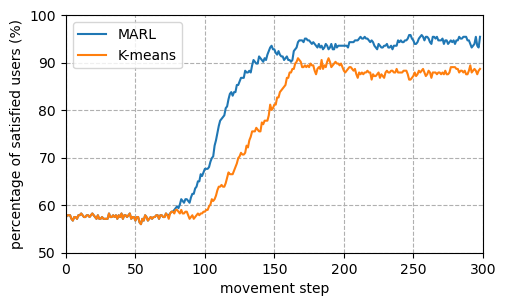

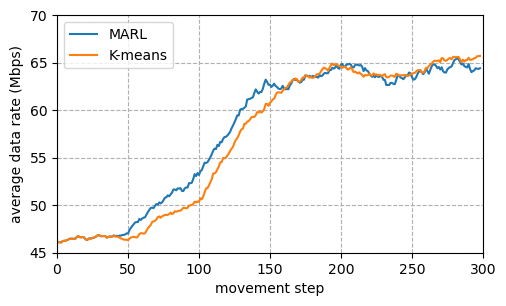

saved data to /mnt/newdiskpartition/uavbs-placement-marl/code/comp/


In [ ]:
import pandas as pd
import os

def to_excel(kpis, path):
    for name, kpi in kpis.items():
        df = pd.DataFrame(kpi)
        df.to_excel(path + f"{name}.xlsx")

path = "comp/"
kpis = {
    "avg_data_rate": log_avg_drates_dict,
    "n_satisfied_users": log_n_satisfied_dict
}
to_excel(kpis=kpis, path=path)
plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict, path=path)

print(f"saved data to {os.path.join(os.getcwd(), path)}")


### Training logs

run 1: selected_Mar18_22-31-18_ccl-ubuntu-20-04 (20k, run 2).csv
run 2: selected_Mar21_12-54-17_ccl-ubuntu-20-04 (20k, run 4, lr=0.5e-3).csv
run 3: selected_Mar23_10-11-26_ccl-ubuntu-20-04 (20k, run 7, dr_rw=0.2).csv
run 4: selected_Mar20_19-36-16_ccl-ubuntu-20-04 (30k, run 2).csv
run 5: selected_Mar17_21-28-40_ccl-ubuntu-20-04 (20k, run 1).csv


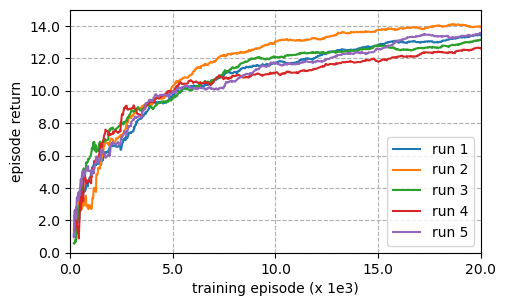

run 1: selected_Mar18_22-31-18_ccl-ubuntu-20-04 (20k, run 2).csv
run 2: selected_Mar21_12-54-17_ccl-ubuntu-20-04 (20k, run 4, lr=0.5e-3).csv
run 3: selected_Mar23_10-11-26_ccl-ubuntu-20-04 (20k, run 7, dr_rw=0.2).csv
run 4: selected_Mar20_19-36-16_ccl-ubuntu-20-04 (30k, run 2).csv
run 5: selected_Mar17_21-28-40_ccl-ubuntu-20-04 (20k, run 1).csv


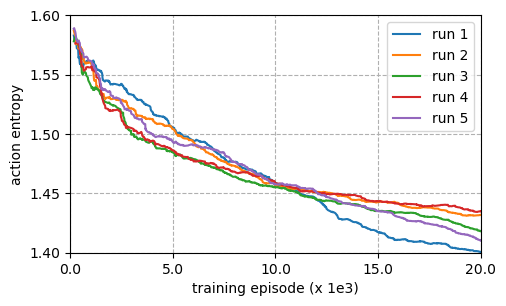

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

figsize = (5, 3)

""" PLOT EPISODE RETURN """
fpath = "runs/selected/episode_return/"
files = os.listdir(fpath)    
csv_files = list(filter(lambda f: f.endswith('.csv'), files))
fig, ax = plt.subplots(figsize=figsize)
i = 1
for fname in csv_files:
    print(f"run {i}: {fname}")
    df = pd.read_csv(fpath + fname)
    # plt.plot(df.Step, df.Value)
    plt.plot(
        df.Step,
        df.Value.ewm(alpha=0.001, adjust=True, min_periods=10).mean(),
        label=f"run {i}"
    )
    i += 1
ax.set_xlabel('training episode (x 1e3)')
ax.set_ylabel('episode return')
locs, labels = plt.xticks()
ax.set_xticks(locs, locs/1e3)
locs, labels = plt.yticks()
ax.set_yticks(locs, locs)
ax.set_xlim([0, 20000])
ax.set_ylim(bottom=0, top=15)
ax.margins(0, 0)
plt.grid(visible=True, linestyle='--')
ax.legend(loc='lower right')
fig.tight_layout(pad=0.5)
plt.savefig("comp/" + "episode_return.png", dpi=300)
plt.show()

""" PLOT ENTROPY """
fpath = "runs/selected/entropy/"
files = os.listdir(fpath)    
csv_files = list(filter(lambda f: f.endswith('.csv'), files))
fig, ax = plt.subplots(figsize=figsize)
i = 1
for fname in csv_files:
    print(f"run {i}: {fname}")
    df = pd.read_csv(fpath + fname)
    # plt.plot(df.Step, df.Value)
    plt.plot(
        df.Step,
        df.Value.ewm(alpha=0.001, adjust=True, min_periods=10).mean(),
        label=f"run {i}"
    )
    i += 1
ax.set_xlabel('training episode (x 1e3)')
ax.set_ylabel('action entropy')
locs, labels = plt.xticks()
ax.set_xticks(locs, locs/1e3)
# locs, labels = plt.yticks()
# ax.set_yticks(locs, locs)
ax.set_xlim([0, 20000])
ax.set_ylim(bottom=1.4, top=1.6)
ax.margins(0, 0)
plt.grid(visible=True, linestyle='--')
ax.legend(loc='upper right')
fig.tight_layout(pad=0.5)
plt.savefig("comp/" + "action_entropy.png", dpi=300)
plt.show()
